<a href="https://colab.research.google.com/github/ArmandDS/blog-post/blob/main/blog_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is for the blogpost:
**how to train a model for car parts segmentation** that you can found [here](https://armandolivares.tech/). 


# Install the required libraries

In [1]:
!pip -qq install -U  segmentation-models

     |████████████████████████████████| 50 kB 6.7 MB/s 


In [2]:
!pip -qq install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

In [3]:
!git clone https://github.com/dsmlr/Car-Parts-Segmentation.git

Cloning into 'Car-Parts-Segmentation'...
remote: Enumerating objects: 564, done.
remote: Counting objects: 100% (564/564), done.
remote: Compressing objects: 100% (549/549), done.
remote: Total 564 (delta 27), reused 548 (delta 13), pack-reused 0
Receiving objects: 100% (564/564), 24.04 MiB | 35.94 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [4]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
import keras
import tensorflow as tf
import shutil
import re
import albumentations as A
import segmentation_models as sm


### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Create the folders and processing the annotations

In [5]:
coco=COCO('/content/Car-Parts-Segmentation/trainingset/annotations.json')

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [6]:
!mkdir /content/Car-Parts-Segmentation/trainingset/annotations/

In [7]:
I = cv2.imread( '/content/Car-Parts-Segmentation/trainingset/JPEGImages/train300.jpg' )
I.shape

(512, 512, 3)

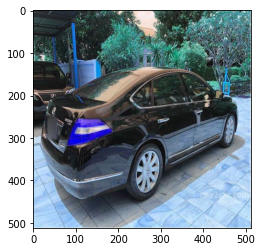

In [8]:
plt.imshow(I)

In [9]:
print(f"The categories Ids: {coco.getCatIds()}")

The categories Ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [10]:
anno_dir = '/content/Car-Parts-Segmentation/trainingset/annotations/'
img_dir = '/content/Car-Parts-Segmentation/trainingset/JPEGImages/'

def create_label_img(anno_dir, img_dir, coco):
  catIds = coco.getCatIds()
  for im_id in coco.getImgIds():
    img = coco.loadImgs(im_id)[0]
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    I = cv2.imread( img_dir + img['file_name'] )
    anns = coco.loadAnns(annIds)
    if isinstance(I, np.ndarray):
      anns_img = np.zeros((I.shape[0], I.shape[1]))
      for i,ann in enumerate(anns):
          if ann['category_id'] != 0:
            anns_img[(coco.annToMask(ann) != 0)] = ann['category_id'] -1
      f_name = img['file_name'].split(".")[0] +'.png'
      cv2.imwrite(anno_dir+ f_name ,anns_img )


create_label_img(anno_dir, img_dir, coco)

In [11]:
x_train_dir = '/content/Car-Parts-Segmentation/trainingset/JPEGImages/'
y_train_dir = '/content/Car-Parts-Segmentation/trainingset/annotations/'

In [12]:
!mkdir /content/Car-Parts-Segmentation/valset
!mkdir /content/Car-Parts-Segmentation/valset/JPEGImages
!mkdir /content/Car-Parts-Segmentation/valset/annotations

In [13]:

    
source_dir = '/content/Car-Parts-Segmentation/testset/JPEGImages/'
target_dir = '/content/Car-Parts-Segmentation/valset/JPEGImages/'

if len(os.listdir(target_dir )) != 50:    
  file_names = os.listdir(source_dir)

  random.shuffle(file_names)

  for file_name in file_names[:50]:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [14]:
x_valid_dir = '/content/Car-Parts-Segmentation/valset/JPEGImages/'
y_valid_dir = '/content/Car-Parts-Segmentation/valset/annotations/'

In [15]:
anno_dir_v = '/content/Car-Parts-Segmentation/valset/annotations/'
img_dir_v = '/content/Car-Parts-Segmentation/valset/JPEGImages/'
coco_v=COCO('/content/Car-Parts-Segmentation/testset/annotations.json')

if len(os.listdir(y_valid_dir))!=50:
  create_label_img(anno_dir_v, img_dir_v, coco_v)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [16]:
print('the number of image/label in the train: ',len(os.listdir(x_train_dir)))
print('the number of image/label in the validation: ',len(os.listdir(x_valid_dir)))

the number of image/label in the train:  400
the number of image/label in the validation:  50


In [17]:
c= ['_background_', 'back_bumper', 'back_glass', 'back_left_door','back_left_light',
 'back_right_door', 'back_right_light', 'front_bumper','front_glass',  
 'front_left_door',  'front_left_light', 'front_right_door',  'front_right_light',  'hood',  'left_mirror',
 'right_mirror', 'tailgate',  'trunk', 'wheel']



* 1	: _background_
* 2	: back_bumper
* 3	: back_glass
* 4	: back_left_door
* 5	: back_left_light
* 6	: back_right_door
* 7	: back_right_light
* 8	: front_bumper
* 9	: front_glass
* 10	: front_left_door
* 11	: front_left_light
* 12	: front_right_door
* 13	: front_right_light
* 14	: hood
* 15	: left_mirror
* 16	: right_mirror
* 17	: tailgate
* 18	: trunk
* 19	: wheel

In [18]:
print(f"Number of Classes: {len(c)}")

Number of Classes: 19


In [19]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = c
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, re.sub(".jpg" , ".png",image_id)) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

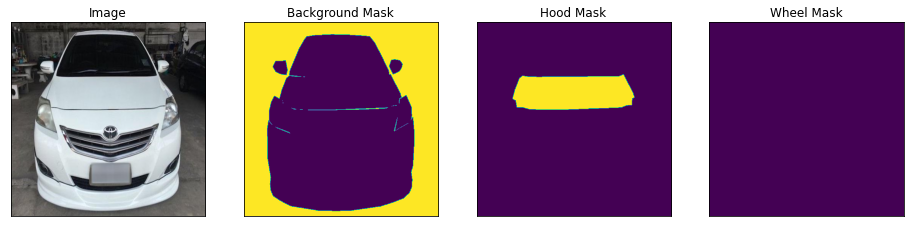

In [20]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=c)

image, mask = dataset[37] # get some sample
visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    hood_mask=mask[..., 13].squeeze(),
    wheel_mask=mask[..., 18].squeeze(),
)

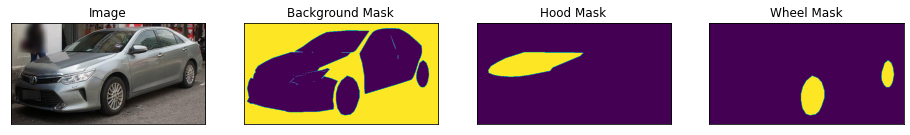

In [112]:
# Lets look at validation data we have
dataset = Dataset(x_valid_dir, y_valid_dir, classes=c)

image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    hood_mask=mask[..., 13].squeeze(),
    wheel_mask=mask[..., 18].squeeze(),
)

# Configure the augmentations

In [22]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.9, border_mode=0),

        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=512, always_apply=True),

        A.GaussNoise (p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.LongestMaxSize(max_size=512),
        A.PadIfNeeded(512, 512, value=[0, 0, 0], border_mode=0)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


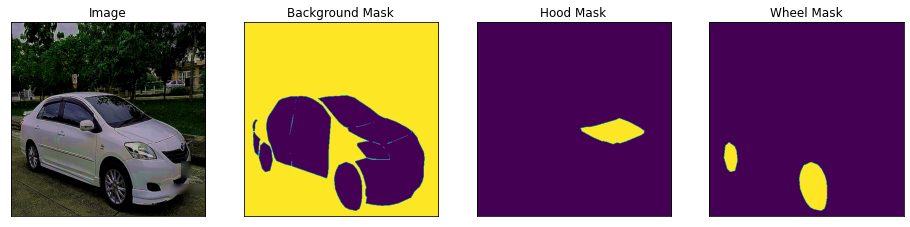

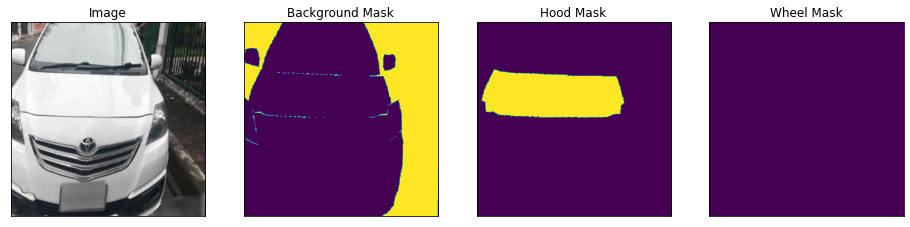

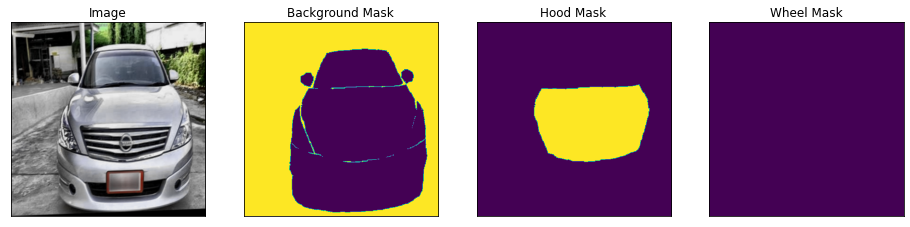

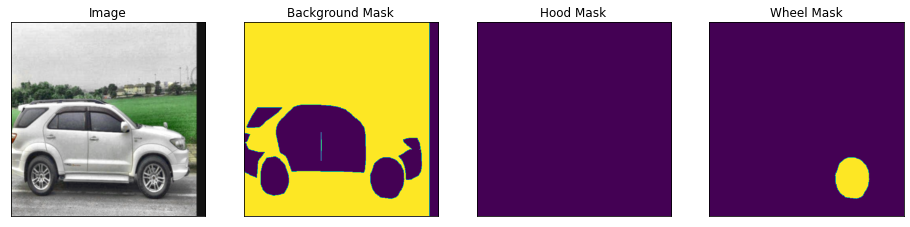

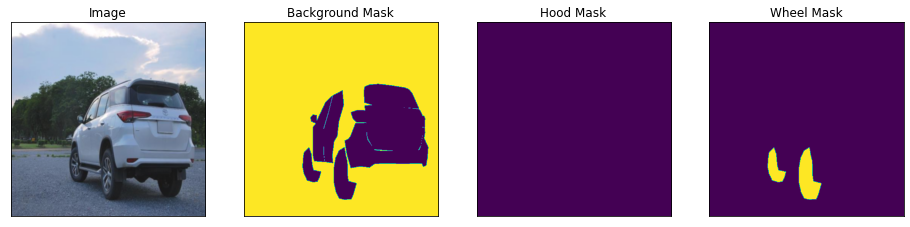

In [23]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=c, augmentation=get_training_augmentation())

for i in range(5):
  image, mask = dataset[i] # get some sample
  visualize(
      image=image, 
      background_mask= mask[..., 0].squeeze(),
      hood_mask=mask[..., 13].squeeze(),
      wheel_mask=mask[..., 18].squeeze(),
  )

# The modeling Part:

In [24]:
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

Select the model parameters:

In [113]:
# define network parameters

BACKBONE = 'resnet18'
BATCH_SIZE = 4
CLASSES = c
LR = 0.0002
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [26]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44933120/44920640 [==============================] - 1s 0us/step


In [27]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss 
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 1,1,2,1,2,1,1.5,1.2,2,1,2,1,1.5,1,1,1,1,2])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimizer, loss and metrics
model.compile(optim, total_loss, metrics)

In [28]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512,512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

assert valid_dataloader[0][0].shape == (1, 512,512, 3)
assert valid_dataloader[0][1].shape == (1, 512, 512, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [29]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
100/100 [==============================] - 143s 1s/step - loss: 0.8725 - iou_score: 0.2555 - f1-score: 0.2818 - val_loss: 0.8781 - val_iou_score: 0.5657 - val_f1-score: 0.5908 - lr: 2.0000e-04
Epoch 2/40
100/100 [==============================] - 121s 1s/step - loss: 0.7139 - iou_score: 0.3389 - f1-score: 0.3831 - val_loss: 0.8134 - val_iou_score: 0.6379 - val_f1-score: 0.6688 - lr: 2.0000e-04
Epoch 3/40
100/100 [==============================] - 128s 1s/step - loss: 0.6207 - iou_score: 0.3673 - f1-score: 0.4176 - val_loss: 0.7724 - val_iou_score: 0.6332 - val_f1-score: 0.6641 - lr: 2.0000e-04
Epoch 4/40
100/100 [==============================] - 122s 1s/step - loss: 0.5499 - iou_score: 0.3879 - f1-score: 0.4377 - val_loss: 0.7607 - val_iou_score: 0.6276 - val_f1-score: 0.6592 - lr: 2.0000e-04
Epoch 5/40
100/100 [==============================] - 124s 1s/step - loss: 0.4797 - iou_score: 0.4037 - f1-score: 0.4627 - val_loss: 0.7220 - val_iou_score: 0.6301 - val_f1-score: 0.66

# The results

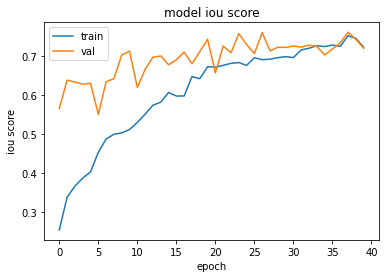

In [30]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('model iou score')
plt.ylabel('iou score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

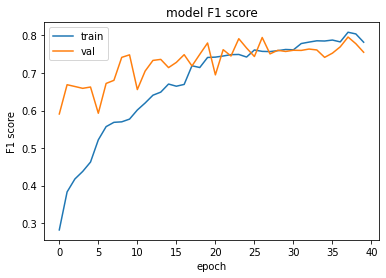

In [31]:
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

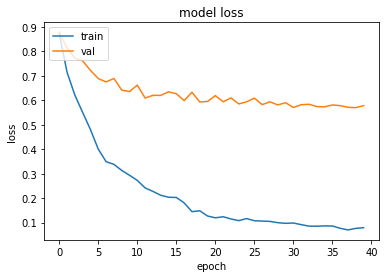

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predictions on the test dataset

In [33]:
!mkdir /content/Car-Parts-Segmentation/testset/annotations

In [34]:
anno_dir_t = '/content/Car-Parts-Segmentation/testset/annotations/'
img_dir_t = '/content/Car-Parts-Segmentation/testset/JPEGImages/'
coco_t=COCO('/content/Car-Parts-Segmentation/testset/annotations.json')

create_label_img(anno_dir_t, img_dir_t, coco_t)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [35]:
x_test_dir = '/content/Car-Parts-Segmentation/testset/JPEGImages/'
y_test_dir = '/content/Car-Parts-Segmentation/testset/annotations/'

In [36]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [37]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.56985
mean iou_score: 0.70817
mean f1-score: 0.74488


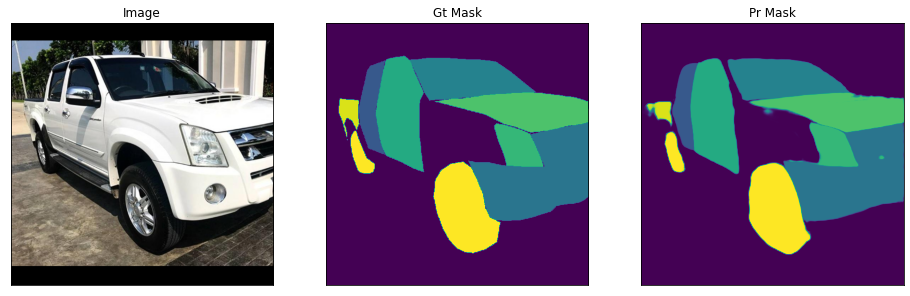

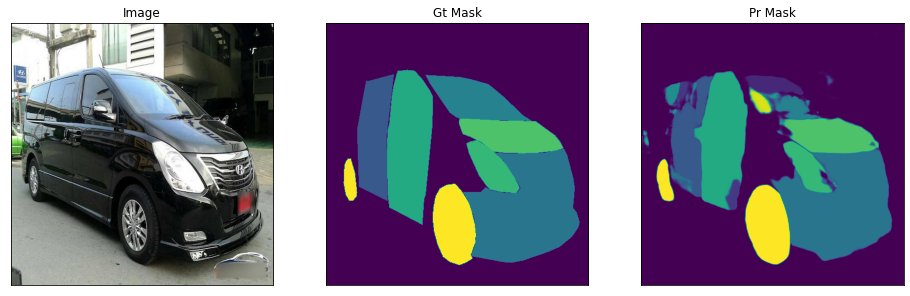

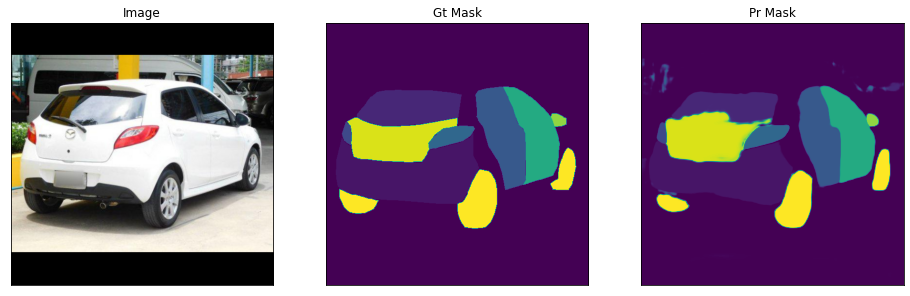

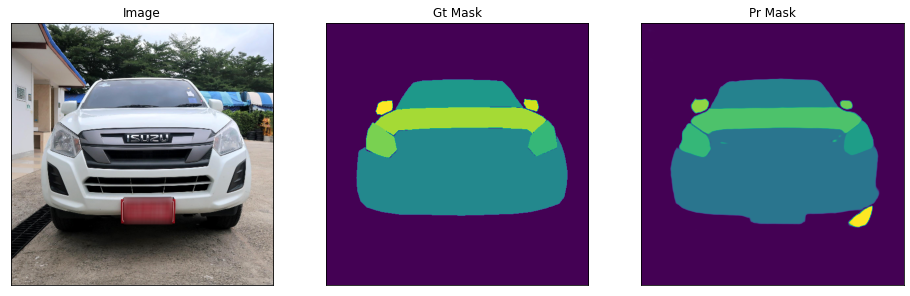

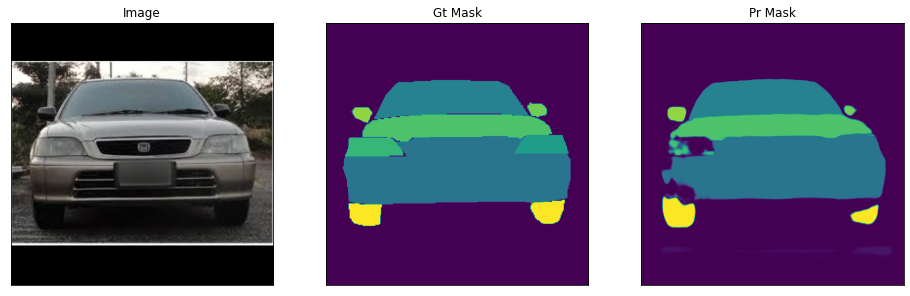

In [39]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).squeeze()

    gt_mask_gray = np.zeros((gt_mask.shape[0],gt_mask.shape[1]))

    for ii in range(gt_mask.shape[2]):
        gt_mask_gray = gt_mask_gray + 1/gt_mask.shape[2]*ii*gt_mask[:,:,ii]
    
    pr_mask_gray = np.zeros((pr_mask.shape[0],pr_mask.shape[1]))
    for ii in range(pr_mask.shape[2]):
        pr_mask_gray = pr_mask_gray + 1/pr_mask.shape[2]*ii*pr_mask[:,:,ii]
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask_gray,
        pr_mask=pr_mask_gray,
    )

# How to use for a random image?

1. Download a random image from internet

In [95]:
!wget https://images.cars.com/cldstatic/wp-content/uploads/chevrolet-volt-2012-exterior-front-three-quarter-oem.jpg -O test_image.jpeg

--2022-09-10 14:42:24--  https://images.cars.com/cldstatic/wp-content/uploads/chevrolet-volt-2012-exterior-front-three-quarter-oem.jpg
Resolving images.cars.com (images.cars.com)... 96.17.118.68
Connecting to images.cars.com (images.cars.com)|96.17.118.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75518 (74K) [image/jpeg]
Saving to: ‘test_image.jpeg’

test_image.jpeg     100%[===================>]  73.75K  --.-KB/s    in 0.02s   

2022-09-10 14:42:25 (3.30 MB/s) - ‘test_image.jpeg’ saved [75518/75518]



In [96]:
from PIL import Image
import numpy as np


def preprocess_image(path_img):
  img = Image.open(path_img)
  ww = 512
  hh = 512
  img.thumbnail((hh, ww))
  i = np.array(img)
  ht, wd, cc= i.shape

  # create new image of desired size and color (blue) for padding
  color = (0,0,0)
  result = np.full((hh,ww,cc), color, dtype=np.uint8)

  # copy img image into center of result image
  result[:ht, :wd] = img
  return result, ht, wd


In [97]:
img_path = '/content/test_image.jpeg'

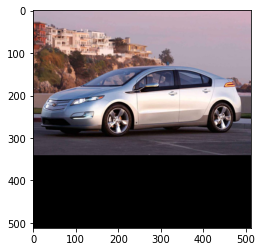

In [98]:
plt.imshow(preprocess_image(img_path)[0])

In [99]:
BACKBONE = 'resnet18'
BATCH_SIZE = 4
LR = 0.0001
EPOCHS = 40
# define network parameters
n_classes = 19
activation =  'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

# load best weights
model.load_weights('/content/best_model.h5') 


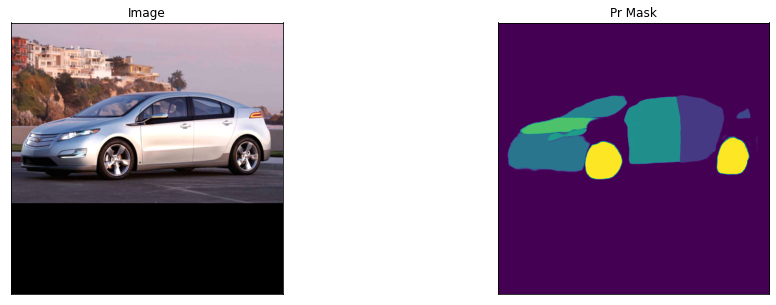

In [109]:

import re

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

n = 1
for i in range(n):
    image = np.expand_dims(preprocess_image(img_path)[0], axis=0)
    pr_mask = model.predict(image).squeeze()

   
    pr_mask_gray = np.zeros((pr_mask.shape[0],pr_mask.shape[1]))
    pr_mask_int = np.zeros((pr_mask.shape[0],pr_mask.shape[1]))
    for ii in range(pr_mask.shape[2]):
        pr_mask_gray = pr_mask_gray + 1/pr_mask.shape[2]*ii*pr_mask[:,:,ii]
    
    visualize(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask_gray,
    )

# Add the legends to the prediction image

In [101]:
import matplotlib.colors as colorsHTML

colors = [ 	(245,255,250), (75,0,130),  (0,255,0), (32,178,170),(0,0,255), (0,255,255), (255,0,255), (128,0,128), (255,140,0),
          (85,107,47), (102,205,170), (0,191,255), (255,0,0), 	(255,228,196), (205,133,63),
          (220,20,60), (255,69,0), 	(143,188,143), (255,255,0)]


In [102]:
def get_legends(class_names, colors, tags):

    n_classes = len(class_names)
    legend = np.zeros(((len(class_names) * 25) + 25, 125, 3),
                      dtype="uint8") + 255

    class_names_colors = enumerate(zip(class_names[:n_classes],
                                       colors[:n_classes]))

    j = 0
    for (i, (class_name, color)) in class_names_colors:
        if i in tags:
          color = [int(c) for c in color]
          cv2.putText(legend, class_name, (5, (j * 25) + 17),
                      cv2.FONT_HERSHEY_COMPLEX, 0.35, (0, 0, 0), 1)
          cv2.rectangle(legend, (100, (j * 25)), (125, (j * 25) + 25),
                        tuple(color), -1)
          j +=1

    return legend


In [103]:
def get_colored_segmentation_image(seg_arr, n_classes, colors=colors):
    output_height = seg_arr.shape[0]
    output_width = seg_arr.shape[1]

    seg_img = np.zeros((output_height, output_width, 3))

    for c in range(n_classes):
        seg_arr_c = seg_arr[:, :] == c
          # print(sum(sum(seg_arr_c)), colors[c] )
        seg_img[:, :, 0] += ((seg_arr_c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg_arr_c)*(colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg_arr_c)*(colors[c][2])).astype('uint8')

    return seg_img/255

(1200, 800)
(1200, 800)


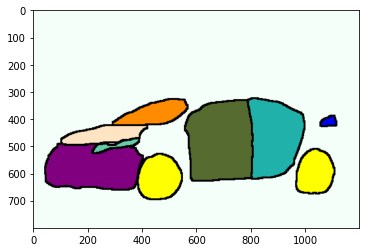

In [104]:
import cv2

img = Image.open(img_path)
tags = []
print(img.size)
img_scaled_arr = preprocess_image(img_path)
print(img.size)
image = np.expand_dims(img_scaled_arr[0], axis=0)
pr_mask = model.predict(image).squeeze()
pr_mask_int = np.zeros((pr_mask.shape[0],pr_mask.shape[1]))
kernel = np.ones((5, 5), 'uint8')
for i in range(1,19):
  array_one = np.round(pr_mask[:,:,i])
  op = cv2.morphologyEx(array_one, cv2.MORPH_OPEN, kernel)
  if sum(sum(op ==1)) > 100:
    tags.append(i)
    pr_mask_int[op ==1] = i 

img_segmented = np.array(Image.fromarray(pr_mask_int[:img_scaled_arr[1], :img_scaled_arr[2]]).resize(img.size))


seg = get_colored_segmentation_image(img_segmented, 19, colors=colors)

fused_img = ((np.array(img)/255)/2 + seg/2).astype('float32')

seg = Image.fromarray((seg*255).astype(np.uint8))
fused_img  = Image.fromarray((fused_img *255).astype(np.uint8))
plt.imshow(seg )

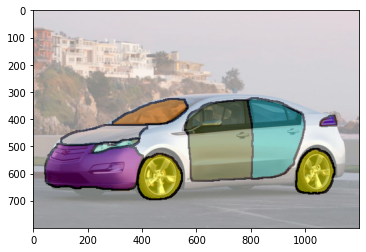

In [105]:
plt.imshow(fused_img )

In [106]:
legend_predicted = get_legends(c, colors, tags)


In [107]:
def concat_lenends(seg_img, legend_img):

    new_h = np.maximum(seg_img.shape[0], legend_img.shape[0])
    new_w = seg_img.shape[1] + legend_img.shape[1]

    out_img = np.zeros((new_h, new_w, 3)).astype('uint8') + legend_img[0, 0, 0]

    out_img[:legend_img.shape[0], :  legend_img.shape[1]] = np.copy(legend_img)
    out_img[:seg_img.shape[0], legend_img.shape[1]:] = np.copy(seg_img)

    return out_img

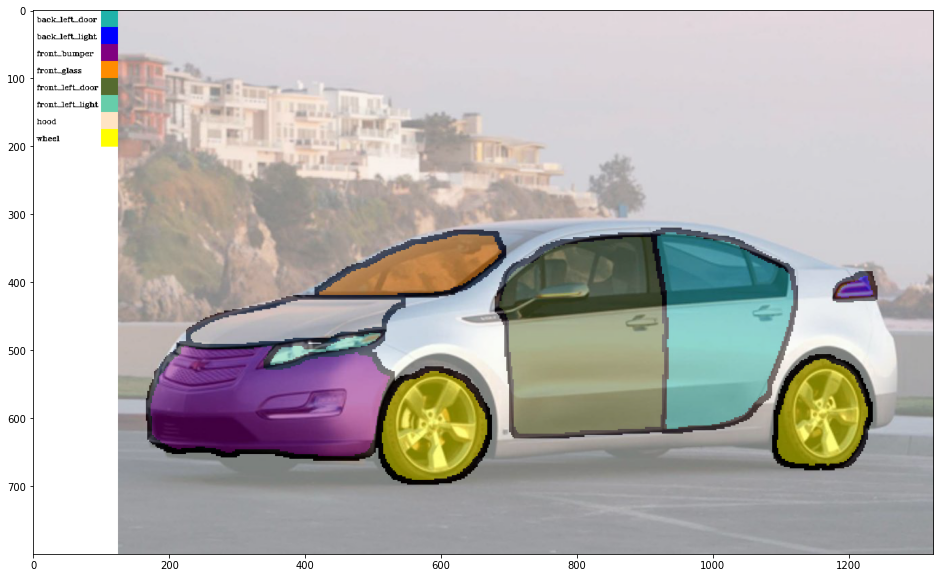

In [108]:
plt.figure(figsize=(20,10))
plt.imshow(concat_lenends(np.array(fused_img), np.array(legend_predicted)))

Pretty good result for this quick model


If you like this post please consider subscribe and follow me on [twitter](http://twitter.com/ArmandOlivares3).